In [19]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations_with_replacement
from functools import reduce
from operator import mul
from math import factorial
import einops
from koopman.simulation.simulator import simulate, simulate_batch, rk4_step
from koopman.simulation.systems import DynamicalSystem, Pendulum
from koopman.edmd.edmd import eDMD
from sklearn.preprocessing import PolynomialFeatures
from spatialmath.base import angle_wrap
from scipy.ndimage import gaussian_filter1d
from sklearn.preprocessing import PolynomialFeatures
from sklearn.kernel_approximation import RBFSampler
from numpy.polynomial.chebyshev import Chebyshev
import scipy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
# def generate_random_smooth_controls(N, T):
#     dt = 0.05
#     w = np.random.randn(N, T, 1) * np.sqrt(dt)
#     b = np.cumsum(w, axis=1)
#     b_smooth = gaussian_filter1d(b, sigma=10, axis=1)
    
#     return b_smooth

# Run a simulation with a pendulum
pendulum = Pendulum(Pendulum.Params(m=1, l=1, g=9.81, b=0.0))

N = 10
theta0 = np.random.uniform(-np.pi, np.pi, (N, 1))
omega0 = np.random.uniform(-1.0, 1.0, (N, 1))
x0 = np.hstack((theta0, omega0))
tf = 5.0
dt = 0.05
T = int(tf/dt)
# controls = generate_random_smooth_controls(N, int(tf/dt))
controls = np.zeros((N, T, 1))

ts, xhist, uhist = simulate_batch(
    sys=pendulum,
    tf=tf,
    dt=dt,
    u=controls,
    x0=x0
)

print("ts:", ts.shape)
print("xhist:", xhist.shape)
print("uhist:", uhist.shape)

Simulation progress: 100%|██████████| 100/100 [00:00<00:00, 19083.23it/s]

ts: (101,)
xhist: (10, 101, 2)
uhist: (10, 100, 1)


In [68]:
def generate_thin_plate_rbf(nx, n_centers):
    centers = np.random.uniform(-2, 2, (n_centers, nx))
    
    def evaluate(X):
        # Compute the radial basis function values
        dists = np.linalg.norm(X[:, None, :] - centers[None, :, :], axis=-1)  # shape: (B, num_centers)
        with np.errstate(divide='ignore', invalid='ignore'):
            rbf = dists**2 * np.log(dists)
            # rbf = np.exp(-(dists/eps) ** 2) # Gaussian RBF
            rbf[np.isnan(rbf)] = 0.0  # set r=0 cases to 0
        
        return rbf
    
    return evaluate

rbf_generator = generate_thin_plate_rbf(nx=Pendulum.nx, n_centers=50)


def koopman_observables(xhist: np.ndarray, deg=None) -> np.ndarray:
    is_batched = xhist.ndim == 2
    if not is_batched:
        xhist = np.expand_dims(xhist, axis=0)
    
    # polyflow features
    null_controls = np.zeros((xhist.shape[0], Pendulum.nu))
    y1 = rk4_step(pendulum.dynamics, xhist, null_controls, dt=dt)
    y2 = rk4_step(pendulum.dynamics, y1, null_controls, dt=dt)
    y3 = rk4_step(pendulum.dynamics, y2, null_controls, dt=dt)
    # y4 = rk4_step(pendulum.dynamics, y3, null_controls, dt=dt)
    # y5 = rk4_step(pendulum.dynamics, y4, null_controls, dt=dt)
    # y6 = rk4_step(pendulum.dynamics, y5, null_controls, dt=dt)
    # y7 = rk4_step(pendulum.dynamics, y6, null_controls, dt=dt)
    # y8 = rk4_step(pendulum.dynamics, y7, null_controls, dt=dt)
    # y9 = rk4_step(pendulum.dynamics, y8, null_controls, dt=dt)
    # y10 = rk4_step(pendulum.dynamics, y9, null_controls, dt=dt)
    Y1 = rbf_generator(xhist)  # shape(B, num_centers)

       
    out = np.concatenate(
        [xhist,
         Y1,
         y1,
         y2,
         y3,
        #  y4,
        #  y5,
        #  y6,
        #  y7,
        #  y8,
        #  y9,
        #  y10
         ], axis=-1
    )
    
    if not is_batched:
        return np.squeeze(out, axis=0)
    else:
        return out

# Fit the eDMD model to pendulum data using degree 4 polynomial observables of sin/cos/omega
edmd = eDMD(nx=Pendulum.nx, nu=Pendulum.nu, bilinear=False)
zhist = edmd.apply_observable_to_history(xhist, koopman_observables)

assert np.allclose(zhist[:, 0, :Pendulum.nx], xhist[:, 0, :])

_ = edmd.fit(zhist , uhist)

Fitting EDMD model with data:
	zhist.shape=(10, 101, 58)
	uhist.shape=(10, 100, 1)
	# of trajectories: 10
	# of time steps: 101
	# of lifted states: 58
	# of controls: 1
Fitting results:
	self.kpA.shape=(58, 58)
	A condition number: 2013013814773056.0
	Residual: 4.2423617003190097e-10


Simulation progress: 100%|██████████| 100/100 [00:00<00:00, 24041.64it/s]

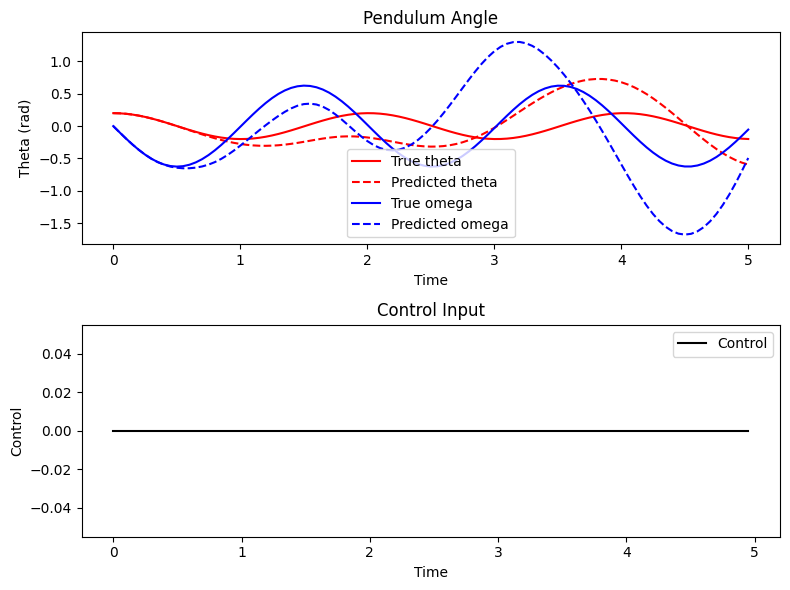

In [70]:
# Evaluate the model on some new data
theta0 = np.random.uniform(-np.pi, np.pi, 1)
omega0 = np.random.uniform(-1.0, 1.0, 1)
x0 = np.concatenate((theta0, omega0))
x0 = np.array([0.2, 0.0])
controls = np.zeros((T, Pendulum.nu))

eval_ts, eval_xhist, eval_uhist = simulate(
    sys=pendulum,
    tf=tf,
    dt=dt,
    u=controls,
    x0=x0
)

zjm1 = koopman_observables(x0, deg=2)

eval_xhist_pred = np.empty_like(eval_xhist)
eval_xhist_pred[0] = edmd.project_to_x(zjm1)

for i, t in enumerate(eval_ts[:-1]):
    zj = edmd.predict_z_next(zjm1, controls[i])
    eval_xhist_pred[i + 1] = edmd.project_to_x(zj)
    
    zjm1 = zj

# Plot the results
fig, ax = plt.subplots(2, 1, figsize=(8, 6))
ax[0].plot(eval_ts, eval_xhist[:, 0], color='red', label="True theta")
ax[0].plot(eval_ts, eval_xhist_pred[:, 0], color='red', label="Predicted theta", linestyle='--')
ax[0].plot(eval_ts, eval_xhist[:, 1], color='blue', label="True omega")
ax[0].plot(eval_ts, eval_xhist_pred[:, 1], color='blue', label="Predicted omega", linestyle='--')
ax[0].set_title("Pendulum Angle")
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Theta (rad)")
ax[0].legend()

ax[1].plot(eval_ts[:-1], eval_uhist[:, 0], color='black', label="Control")
ax[1].set_title("Control Input")
ax[1].set_xlabel("Time")
ax[1].set_ylabel("Control")
ax[1].legend()

plt.tight_layout()
plt.show()

In [73]:
print(
    repr(edmd.kpA)
)

print(
    repr(edmd.kpB)
)

print(
    repr(edmd.kpCs)
)

array([[ 1.00000036e+00,  4.99989972e-02, -1.22630372e-02,
         5.73729317e-08, -2.02405229e-04,  2.54901813e-06,
         2.53553406e-05],
       [ 4.24999056e-05,  9.99891849e-01, -4.90537847e-01,
         6.71898738e-06, -1.20231391e-02,  2.01319270e-04,
         2.00847963e-03],
       [-3.44137539e-04,  8.74112909e-04,  1.00021231e+00,
        -5.39396238e-05,  4.80568204e-02, -1.21582942e-03,
        -1.22468222e-02],
       [ 3.53013819e-05, -7.25291556e-05,  1.14653223e-03,
         9.90487381e-01,  1.38300367e-04, -4.90075216e-05,
        -8.39543712e-05],
       [-2.01399086e-02,  5.12311211e-02, -1.01230312e-03,
        -3.09040242e-03,  8.85143841e-01, -4.68438099e-02,
        -4.80665294e-01],
       [ 7.35181349e-01, -1.84835962e+00,  1.10041353e+00,
         1.05683858e-01,  4.18816647e+00,  7.78549157e-01,
        -3.20071962e-01],
       [ 2.22198524e-03, -8.57630036e-03,  7.10691577e-03,
         1.73321898e-04,  2.20312875e-02, -3.30327084e-04,
         9.3015072

In [75]:
print(np.concatenate(edmd.kpCs, axis=0).shape)

(7, 7)
